<a href="https://colab.research.google.com/github/tojirocky/AI-workshop-/blob/main/copy_%5BSpecial_Student%5DML_Workshop_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install timm torcheval

## Create New API Token from Kaggle

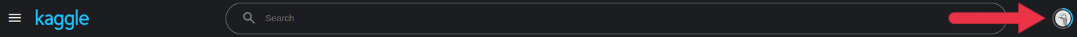

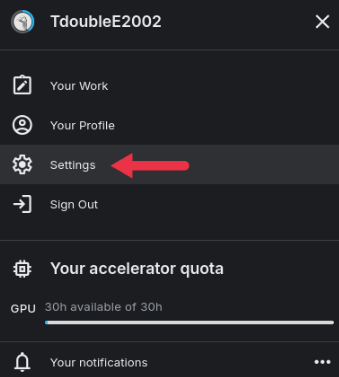

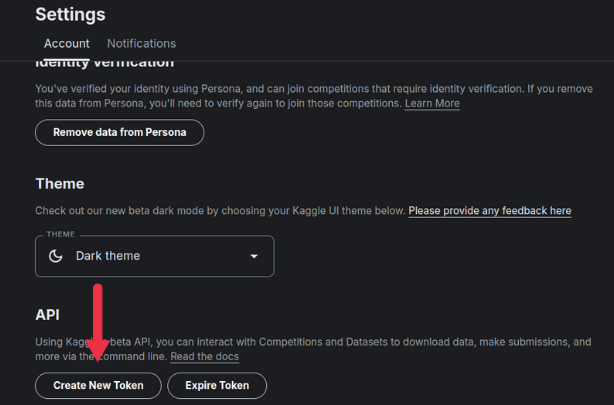

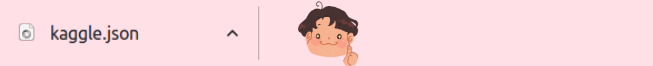

## Import Data from Kaggle

In [21]:
!pip install -q kaggle

* upload kaggle.json file

In [22]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"denpoom","key":"0971281685a031ecbdf65c9a24bbbb66"}'}

In [23]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c EECU-Gewertz-AI-workshop-special-01
!mkdir /content/Dataset
!unzip EECU-Gewertz-AI-workshop-special-01.zip -d /content/Dataset
!rm -rf EECU-Gewertz-AI-workshop-special-01.zip
!rm -rf kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                  Student Performance Predictions                 9KB  2024-08-17 06:57:57           2124         49  0.9411765        
berkayalan/paris-2024-olympics-medals                         Paris 2024 Olympics Medals                      1KB  2024-08-14 11:02:45           2712         52  1.0              
x1akshay/olympics-2024                                        Olympics 2024                                   4KB  2024-08-12 05:54:05           1394         32  1.0              
souradippal/student-performance-predicti

## Explore and Prepare Data

In [24]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import make_grid
from torcheval.metrics import MulticlassAccuracy
from torch.cuda.amp import GradScaler, autocast
import timm
from joblib import load, dump

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 2.3.1+cu121
Albumentations version 1.4.14


In [25]:
DATA_DIR = '/content/Dataset/'
SEED = 42

### Define Helper Function

In [26]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")


def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/

    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result

### Check class distribution

In [27]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

,filename,label
0,003e3ac1997d44fc885426823fca31c3.jpeg,5
1,0040ae2e97414ce8ae7d02d067024361.jpeg,1
2,005a71fd86ca46028146ed130f76696f.jpeg,2
3,005edcf9bc424627934767b4a4813b31.jpeg,5
4,0074786262a84abc836810ef460cee87.jpeg,2


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

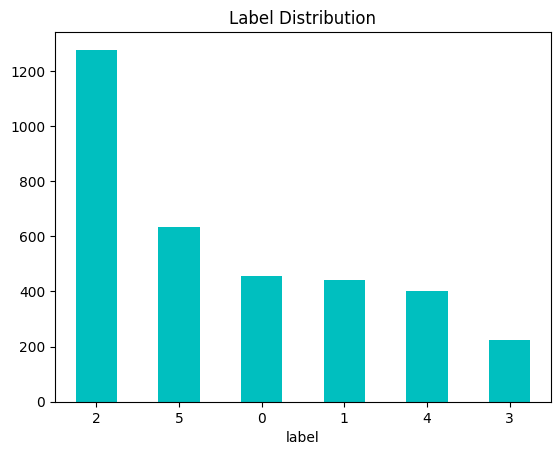

In [28]:
df['label'].value_counts().plot(kind='bar', rot=0, title='Label Distribution', color='c')

### Check Image Shape

In [29]:
img_shape = set()
img_ext = set()
img_names = Path(DATA_DIR+'train/').glob('*')
pbar = tqdm(img_names, total=len(df))
for img_name in pbar:
    img = load_img(img_name.as_posix())
    img_shape.add(img.shape)
    img_ext.add(img_name.suffix)
print(f'Image shapes are {img_shape}.')
print(f'Image extensions are {img_ext}.')

  0%|          | 0/3432 [00:00<?, ?it/s]

Image shapes are {(215, 234, 3), (225, 300, 3), (200, 139, 3), (220, 220, 3), (900, 900, 3), (480, 640, 3), (3210, 3211, 3), (397, 397, 3), (211, 239, 3), (131, 352, 3), (525, 700, 3), (425, 398, 3), (4193, 4193, 3), (189, 267, 3), (641, 640, 3), (242, 490, 3), (296, 300, 3), (140, 361, 3), (600, 600, 3), (150, 200, 3), (188, 268, 3), (3049, 3049, 3), (400, 400, 3), (560, 560, 3), (401, 500, 3), (187, 270, 3), (146, 220, 3), (194, 260, 3), (100, 100, 3), (223, 226, 3), (224, 224, 3), (199, 285, 3), (505, 785, 3), (180, 279, 3), (157, 321, 3), (3820, 3820, 3), (640, 640, 3), (205, 246, 3), (320, 320, 3), (480, 600, 3), (350, 350, 3), (194, 501, 3), (224, 225, 3), (1000, 1000, 3), (146, 346, 3), (195, 258, 3), (179, 281, 3), (450, 600, 3), (202, 250, 3), (237, 213, 3), (200, 206, 3), (228, 221, 3), (187, 501, 3), (1410, 1410, 3), (240, 210, 3), (240, 320, 3), (2851, 2851, 3), (128, 256, 3), (2369, 2369, 3), (164, 307, 3), (470, 470, 3), (260, 350, 3), (197, 200, 3), (375, 568, 3), (149, 

### Sample plot in each class

In [30]:
transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToDtype(torch.float32, scale=True) # Convert images to PyTorch tensors
])

In [31]:
# Store unique labels and their corresponding images
unique_labels = set()
img_tensors = []
labels = []

for index, row in df.iterrows():
    if row['label'] not in unique_labels:
        img_path = Path(DATA_DIR) / 'train' / row['filename']
        image = read_image(str(img_path))
        image = transform(image)  # Ensure that the transform is applied correctly to the image tensor
        img_tensors.append(image)
        labels.append(row['label'])  # Store the label for each image
        unique_labels.add(row['label'])

    # Stop once we collect one image for each of the six classes
    if len(unique_labels) == 6:
        break

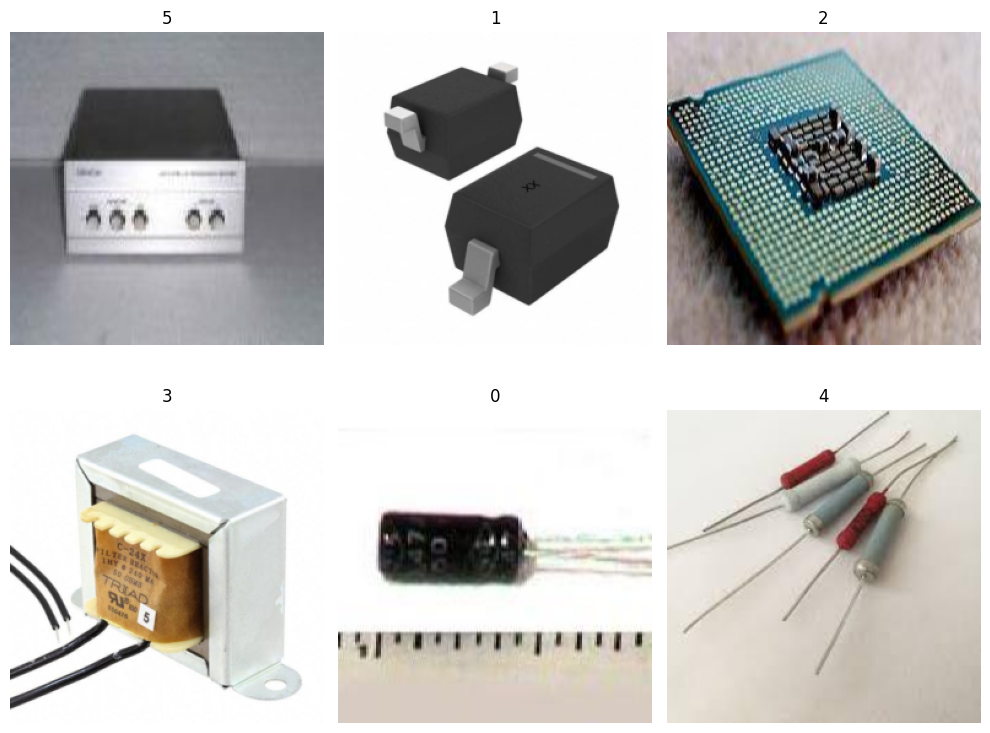

In [32]:
def show(img_tensors, labels, nrow=3):
    num_images = len(img_tensors)
    fig, axes = plt.subplots(nrows=(num_images + nrow - 1) // nrow, ncols=nrow, figsize=(10, 8))
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(zip(img_tensors, labels)):
        axes[i].imshow(img_tensor.permute(1, 2, 0))  # Permute tensor to match image dimensions
        axes[i].set_title(label, fontsize=12)
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

# Display images with their labels
show(img_tensors, labels, nrow=3)

## Build Model

#### fighting!!

## Predict Submission

In [33]:
submission_df = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [34]:
print(f'==========Start Inference==========')
with torch.no_grad():
    test_preds = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, img in pbar:
        img = img.to(device).float()
        test_output = model(img)
        test_preds += [torch.argmax(test_output, 1).detach().cpu().numpy()]
    test_preds = np.concatenate(test_preds)
submission_df['label'] = test_preds
submission_df

==========Start Inference==========


NameError: name 'test_loader' is not defined

In [ ]:
submission_df.to_csv('submission.csv', index=False)